# Portfolio Project: Scrape and analyze data analyst job requirements with Python

## Overview

In this project, you will step into the shoes of an entry-level data analyst at medium-sized recruitment agency, helping to improve its sourcing of job vacancies.

## Project Scenario

The team at the recruitment agency is trying to improve its sourcing of job vacancies. To do this the agency relies on multiple job posting sites to identify potential job openings for its clients. However, manually searching through each site is time-consuming and often leads to missed opportunities.  

They want you to  analyze the data using web scraping tools that can automatically extract job posting data from multiple job posting sites.  The team will use your analysis to provide a more efficient way to provide job vacancies to better serve its clients. This feature will help the recruitment agency by getting relevant openings to their clients more quickly, giving their clients a competitive advantage over other applicants.

## Project Objectives

* Increase the efficiency of job vacancy sourcing
* Improve the quality of job vacancy sourcing
* Gain a competitive advantage  

## Your Challenge

Your task will be to conduct a web scraping data analysis to automatically extract job posting data from a job posting site. To do this, you will  set up the environment, identify the job posting site, scrape the data,  process, analyze, and visualize the data.

In this project, we'll use data from a job posting site; however, to keep this project unique and open-ended, please feel free to choose whichever major job posting website you'd prefer - please note that some sites have an anti-scraping filter which can affect your results.

After you perform your analysis, you will share your findings.

# Import necessary modules

In [3]:
import requests
from bs4 import BeautifulSoup
import warnings
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Scraping

In [176]:
# Create an empty list for the job cardss
job_cards = []

# The site only displays a limited number of matching jobs at a time,
# so we need to go through each page individually to collect all the job listings.
for page_number in range(1, 300):
    url = f"https://www.profession.hu/en/advertisements/budapest/{page_number},0,23"
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.text, "html.parser")
    job_cards.extend(soup.find_all("li", class_="job-card"))

In [177]:
# Create an empty Pandas dataframe for the jobs
df_jobs_raw = pd.DataFrame()

# Loop through the list of job cards and extract the job details into the df_jobs_raw DataFrame.
for job in job_cards:
    
    # Job cards contain a varying number of tags. First, we
    # extract these tags into a list so we can later add them to the DataFrame.
    job_tags = job.find_all("span", class_="job-card__tag")
    
    # Create a job item by extracting relevant data from the job object.
    job_item = {
        "affiliation" : job.get("data-affiliation"),
        "item-name" : job.get("data-item-name"),
        "application_type" : job.get("data-application_type"),
        "category1" : job.get("data-category1"),
        "category2" : job.get("data-category2"),
        "category3" : job.get("data-category3"),
        "category4" : job.get("data-category4"),
        "category5" : job.get("data-category5"),
        "category6" : job.get("data-category6"),
        "currency" : job.get("data-currency"),
        "item-brand" : job.get("data-item-brand"),
        "item-id" : job.get("data-item-id"),
        "item-name" : job.get("data-item-name"),
        "link" : job.get("data-link"),
        "linktarget" : job.get("data-linktarget"),
        "list-id" : job.get("data-list-id"),
        "list-index" : job.get("data-list-index"),
        "list-name" : job.get("data-list-name"),
        "location-id" : job.get("data-location-id"),
        "price" : job.get("data-price"),
        "prof-category" : job.get("data-prof-category"),
        "prof-id" : job.get("data-prof-id"),
        "prof-name" : job.get("data-prof-name"),
        "prof-position" : job.get("data-prof-position"),
        "prof_product_name" : job.get("data-prof_product_name"),
        "quantity" : job.get("data-quantity"),
        "row-number" : job.get("data-row-number"),
        "value" : job.get("data-value"),
        "variant" : job.get("data-variant"),
        "id" : job.get("id"),
        
        # In this step, the previously extracted job tags are stored.
        # Each string in the list is preprocessed to remove whitespace and
        # convert the text to lowercase, making them easier to compare.
        "job_tags" : [job_tags[i].text.replace(" ", "").strip().lower() for i in range(len(job_tags))]
    }
    # Add a new job_item row to the DataFrame.
    df_jobs_raw = pd.concat([df_jobs_raw, pd.DataFrame([job_item])], ignore_index=True)

In [189]:
# Extract salary information from job_tags.
# Specifically, retrieve the first list items that contain the substring 'huf'.
df_jobs_raw["salary"] = df_jobs_raw["job_tags"].apply(lambda tags: next((tag for tag in tags if  "huf" in tag.lower()), None))

# Extract expected language skill information from job_tags.
# Specifically, retrieve the first list items that contain substrings related to language proficiency levels.
keywords = ["-basic", "-intermediate", "-higher", "-native"]
df_jobs_raw["language_skill"] = df_jobs_raw["job_tags"].apply(lambda tags: next(
        (
            tag for tag in tags if any(keyword in tag.lower() for keyword in keywords)
        ), None
    )
)
df_jobs_raw.index.name = "index"

# To save time, store the raw dataset so we don’t need to re-fetch the content from the website later.
df_jobs_raw.to_csv("df_jobs_raw.csv")

# Cleaning

In [4]:
# Load the previously saved file to begin the data cleaning process.
df_jobs = pd.read_csv("df_jobs_raw.csv", index_col="index")

# Drop the "price" and "value" columns, as they contain only null values.
# Drop the following columns because they appear to serve as index or identifier fields:
# "prof-position", "item-id", "list-id", "list-index", "prof-id", "row-number", "id".
# Drop "item-brand" because its values duplicate those in the "affiliation" column.
# Drop "category5" as it duplicates the values in "category3".
# Drop "currency", "linktarget", and "quantity" since they contain only a single unique value across all rows.
# Drop "link" and "list-name" because they do not provide any relevant information.
# Drop "category6" as it duplicates the values in "location-id".
# Drop "job_tags" since all relevant information has already been extracted into separate columns.
# Drop "variant" because it contains redundant information already captured in the salary column.
# Drop "item-name" as it duplicates the values in "prof-name".
# Drop "prof-category" because it is simply a numeric representation of "category1".
columns_to_drop = [
    "price", "value", "prof-position", "item-id", "list-index", "item-brand",
    "category5", "currency", "linktarget", "list-id", "link", "list-name",
    "category6", "quantity", "prof-id", "row-number", "id", "job_tags", "variant",
    "item-name", "prof-category"
]
df_jobs.drop(columns_to_drop, axis=1, inplace=True)

# Rename columns to better reflect the actual data they contain and to ensure consistent naming conventions.
df_jobs.rename(columns={
    "category1":"prof_category_1",
    "category2":"prof_category_2",
    "category3":"employment_type",
    "category4":"expected_experience",
    "location-id":"location",
    "prof-name":"prof_name",
    "prof_product_name":"subscr_product_name"
}, inplace=True)

We have a "salary" column, but its values are stored as strings, and the actual salary information is embedded in various formats. These strings may refer to different time periods (e.g., monthly or hourly), salary ranges, and whether the amount is net or gross.

Examples include:
- net500k-800khuf/month
- gross1,0m-2,0mhuf/month
- net400khuf/month
- gross1700-3400huf/hour
- net2300-2500huf/hour
- etc.

Because of this inconsistency, we need to extract the actual salary values from these text strings for further analysis.64

In [5]:
def extract_salary_info(text):
    
    # Initialize all salary-related variables to None
    salary_type = salary_currency = salary_period = salary_min = salary_prefix_min = salary_max = salary_prefix_max = None
    
    # Extract the salary type (gross or net) from the text
    match_salary_type = re.search(r'(gross|net)', text)
    if match_salary_type:
        salary_type = match_salary_type.group()
    
    # Extract the currency (e.g., HUF) from the text   
    match_salary_currency = re.search(r'(huf)', text)
    if match_salary_currency:
        salary_currency = match_salary_currency.group()
    
    # Extract the salary period (e.g., per month, hour, or year)
    match_salary_period = re.search(r'(month|hour|year)', text)
    if match_salary_period:
        salary_period = match_salary_period.group()
        
    # Extract the minimum salary value (e.g., 1.2 or 300)
    match_salary_min = re.search(r'\d+(,|)\d+', text)
    if match_salary_min:
        salary_min = match_salary_min.group().replace(",", ".")
    
    # Extract the prefix for the minimum salary (e.g., 'k' for thousand, 'm' for million)
    match_salary_prefix_min = re.search(r'(m|k)(-|h)', text)
    if match_salary_prefix_min:
        salary_prefix_min = match_salary_prefix_min.group(1)
    
    # Extract the maximum salary value (e.g., 500 or 1.5)
    match_salary_max = re.search(r'-(\d+)(,|)(\d+)', text)
    if match_salary_max:
        salary_max = "".join(match_salary_max.group(1, 2, 3)).replace(",", ".")
    
    # Extract the prefix for the maximum salary (e.g., 'k' or 'm' before 'huf')
    match_salary_prefix_max = re.search(r'(m|k)(huf)', text)
    if match_salary_prefix_max and salary_max != None:
        salary_prefix_max = match_salary_prefix_max.group(1)
    
    # Convert the minimum salary to a float and scale it based on the prefix
    salary_min = float(salary_min) * (1000 if salary_prefix_min == "k" else 1000000 if salary_prefix_min == "m" else 1)
    
    # Convert the maximum salary to a float and scale it based on the prefix (default to 0 if not found)
    salary_max = float(salary_max or 0) * (1000 if salary_prefix_max == "k" else 1000000 if salary_prefix_max == "m" else 1)
    
    # Calculate the average salary (use the minimum if the maximum is not provided)
    average_salary = salary_min if salary_max == 0 else (salary_min + salary_max) / 2

    
    # Normalize the salary to a gross monthly amount:
    # - If yearly, divide by 12
    # - If hourly, multiply by 168 (approx. hours/month)
    # - If net, convert to gross by dividing by 0.66
    gross_monthly_salary =  int((average_salary / 12 if salary_period == "year"
                        else average_salary * 168 if salary_period == "hour"
                        else average_salary) * (1 / 0.66 if salary_type == "net" else 1))
                            
    
    return int(gross_monthly_salary)

# Apply the salary extraction function to the 'salary' column where values are not null
df_jobs["gross_monthly_salary HUF"] = df_jobs[df_jobs["salary"].isnull() == False]["salary"].apply(lambda x: pd.Series(extract_salary_info(x)))
# Convert the salary from HUF to EUR
df_jobs["gross_monthly_salary EUR"] = df_jobs["gross_monthly_salary HUF"] / 403

In [6]:
# Set lower and upper bounds to identify salary outliers
lower_bound = 200000
upper_bound = 2000000

# Identify rows where the salary falls outside the defined range
outliers = df_jobs[(df_jobs['gross_monthly_salary HUF'] < lower_bound) | (df_jobs['gross_monthly_salary HUF'] > upper_bound)]

# Remove the outlier rows from the DataFrame
df_jobs = df_jobs.drop(outliers.index)
print(f'{len(outliers)} outliers were dropped')

16 outliers were dropped


In the "language_skill" column, the nationality and the required language proficiency level are combined into a single string. We need to extract these into two separate columns.

In [7]:
def extract_language_info(text):

    # Initialize variables for nationality and language level
    language_nationality = language_level = None

    # Extract nationality and language level from the text (e.g., "english-intermediate")
    match_language_nationality = re.search(r"([a-zA-Z]+)-([a-zA-Z]+)", text)
    if match_language_nationality:
        language_nationality = match_language_nationality.group(1)
        language_level = match_language_nationality.group(2)

    return language_nationality, language_level

# Apply the extraction function to the 'language_skill' column
# and split the results into two new columns: 'language_nationality' and 'language_level'
df_jobs[["language_nationality", "language_level"]] = df_jobs[df_jobs["language_skill"].isnull() == False]["language_skill"].apply(lambda x: pd.Series(extract_language_info(x)))

In [8]:
# After extracting the salary and language skill information into separate columns,
# we can drop the original 'salary' and 'language_skill' columns.
columns_to_drop = ["salary", "language_skill"]
df_jobs.drop(columns_to_drop, axis=1, inplace=True)

# There are a few null values in the 'affiliation' and 'location' columns,
# so we can safely drop these rows without significant data loss.
df_jobs.dropna(subset=["affiliation", "location"], inplace=True)

In [9]:
# Fill missing values in the 'language_nationality', and 'language_level' columns.
# For language-related columns, use "none" as a placeholder for missing values.
df_jobs[["language_nationality", "language_level"]] = df_jobs[["language_nationality", "language_level"]].fillna("none")

In [10]:
# We're only interested in full-time positions, so we filter the DataFrame to keep only those rows.
df_jobs = df_jobs[df_jobs["employment_type"] == "full time"]

In [11]:
# The 'expected_experience' column contains lengthy text values, so we shorten them for better readability.
df_jobs["expected_experience"] = df_jobs["expected_experience"].replace({
    'professional experience is not required' : "not required",
    'Career starter/freshly graduated' : "starter",
    '1-3 years experience' : "1-3 years",
    '3-5 years experience' : "3-5 years",
    '5-10 years experience' : "5-10 years",
    '>10 years experience' : "10+ years"
})

In [12]:
df_jobs.to_csv("df_jobs_cleaned.csv")

# Exploratory Data Analysis (EDA)

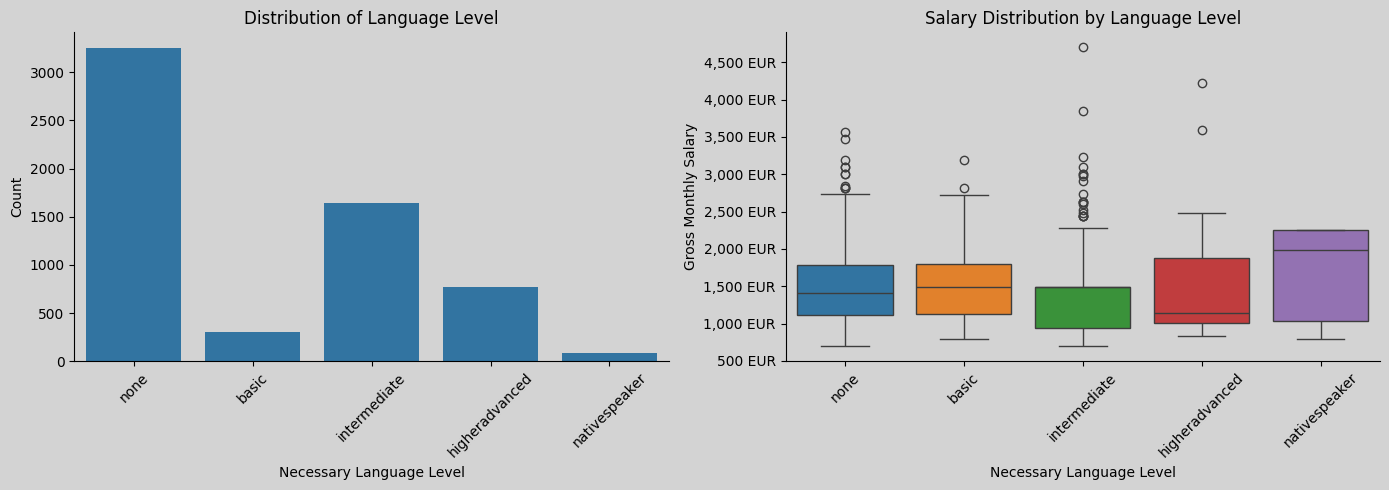

In [13]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="lightgrey")

order=["none", 'basic', 'intermediate', 'higheradvanced', 'nativespeaker']

# First subplot: Countplot
# (sns.histplot don't support ordering labels so we have to use sns.countplot)
sns.countplot(
    data=df_jobs,
    x="language_level",
    order=order,
    ax=axes[0]
)

axes[0].set_facecolor("lightgrey")
axes[0].set_xlabel("Necessary Language Level")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Language Level")
axes[0].tick_params(axis='x', rotation=45)

# Remove right and top spines from first subplot
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Second subplot: Boxplot
sns.boxplot(
    data=df_jobs,
    x="language_level",
    order=order,
    y="gross_monthly_salary EUR",
    hue="language_level",
    ax=axes[1]
)


# Format y-axis ticks to show EUR currency
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,} EUR')

axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_facecolor("lightgrey")
axes[1].set_xlabel("Necessary Language Level")
axes[1].set_ylabel("Gross Monthly Salary")
axes[1].set_title("Salary Distribution by Language Level")
axes[1].tick_params(axis='x', rotation=45)

# Remove right and top spines from second subplot
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Adjust layout
plt.tight_layout()

As we can see, most jobs that require language skills demand an intermediate level of proficiency. The distribution of language levels is noticeably uneven, with a significant difference in the number of listings across levels.

While we initially expected clearer distinctions in salary distributions based on language proficiency, the data tells a different story. The intermediate and higher advanced levels show very similar salary patterns. Although basic and native speaker levels differ more noticeably, the gap is still smaller than anticipated.

This suggests that language proficiency may not be a primary factor influencing salary. Instead, profession type and years of experience likely play a more significant role in determining compensation.

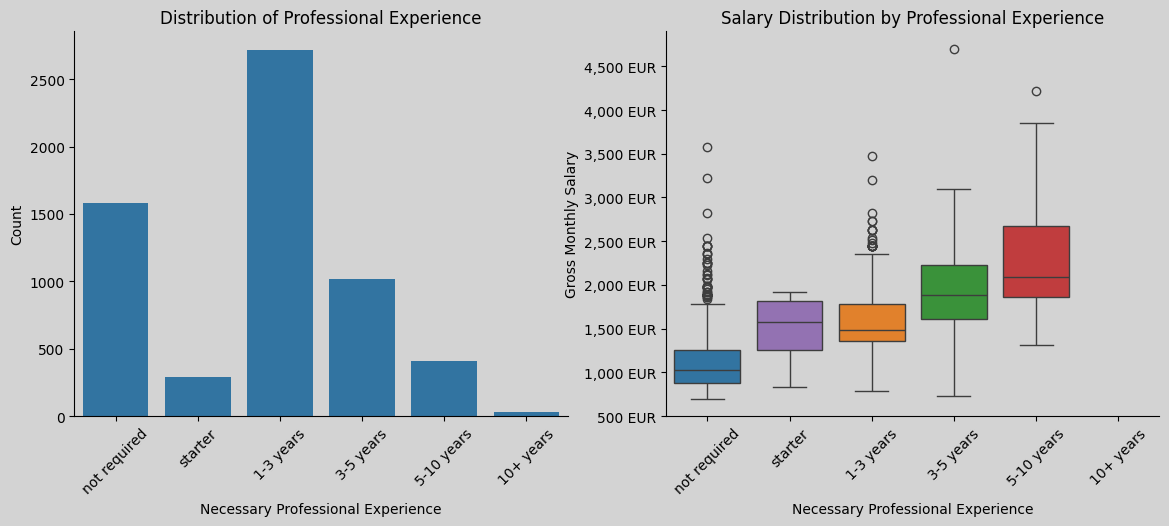

In [14]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="lightgrey")

order = ['not required', 'starter', '1-3 years', '3-5 years', '5-10 years', '10+ years']

# First subplot: Countplot
# sns.histplot don't support ordering labels so we have to use sns.countplot
sns.countplot(
    data=df_jobs,
    x="expected_experience",
    order=order,
    ax=axes[0]
)

axes[0].set_facecolor("lightgrey")
axes[0].set_xlabel("Necessary Professional Experience")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Professional Experience")
axes[0].tick_params(axis='x', rotation=45)

# Remove right and top spines from first subplot
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Second subplot: Boxplot
sns.boxplot(
    data=df_jobs,
    x="expected_experience",
    order=order,
    y="gross_monthly_salary EUR",
    hue="expected_experience",
    ax=axes[1]
)

# Format y-axis ticks to show EUR currency
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,} EUR')

axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_facecolor("lightgrey")
axes[1].set_xlabel("Necessary Professional Experience")
axes[1].set_ylabel("Gross Monthly Salary")
axes[1].set_title("Salary Distribution by Professional Experience")
axes[1].tick_params(axis='x', rotation=45)

# Remove right and top spines from second subplot
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

As we initially assumed, salary appears to be more strongly influenced by work experience than by language proficiency. One interesting insight is that individuals at the "Starter" level and those with "1–3 years" of experience tend to earn roughly the same salary. This suggests that having 1–3 years of experience may not offer a significant salary advantage over having no experience at all.

A possible conclusion is that early-career professionals may need to accumulate at least 3 years of experience before seeing a noticeable increase in salary.

In [15]:
# We are curious about data related jobs so we create a filtered dataset that contains only these kind oj jobs
df_data_jobs = df_jobs[df_jobs["prof_category_2"].str.contains("data", case=False, na=False)]
df_data_jobs["prof_category_2"].value_counts()

prof_category_2
Data Analyst               20
Database Expert            20
Data Protection Officer     4
Name: count, dtype: int64

Although the dataset contains only a small number of data-related jobs, we still analyzed them using the same visualizations we previously used to explore the relationship between expected professional experience and offered salaries.

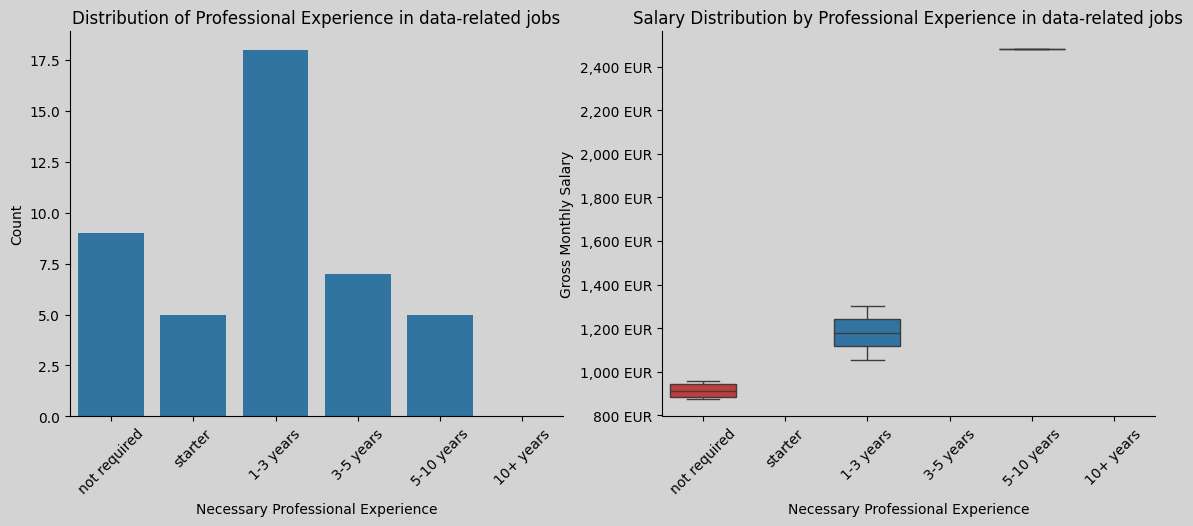

In [16]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="lightgrey")

order = ['not required', 'starter', '1-3 years', '3-5 years', '5-10 years', '10+ years']

# First subplot: Countplot
# sns.histplot don't support ordering labels so we have to use sns.countplot
sns.countplot(
    data=df_data_jobs,
    x="expected_experience",
    order=order,
    ax=axes[0]
)

axes[0].set_facecolor("lightgrey")
axes[0].set_xlabel("Necessary Professional Experience")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Professional Experience in data-related jobs")
axes[0].tick_params(axis='x', rotation=45)

# Remove right and top spines from first subplot
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Second subplot: Boxplot
sns.boxplot(
    data=df_data_jobs,
    x="expected_experience",
    order=order,
    y="gross_monthly_salary EUR",
    hue="expected_experience",
    ax=axes[1]
)

# Format y-axis ticks to show EUR currency
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,} EUR')

axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_facecolor("lightgrey")
axes[1].set_xlabel("Necessary Professional Experience")
axes[1].set_ylabel("Gross Monthly Salary")
axes[1].set_title("Salary Distribution by Professional Experience in data-related jobs")
axes[1].tick_params(axis='x', rotation=45)

# Remove right and top spines from second subplot
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

As we can see, most jobs include some level of expected professional experience. Due to limited data, the salary distribution doesn't provide a clear picture, but the main takeaway is that there appears to be a strong relationship between experience and salary.